In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from tqdm import tqdm
import os
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter
from torch.optim import lr_scheduler
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy




device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Define your train val test dataset

In [66]:
from torchvision import datasets, transforms


input_path = "./datasets/alien-vs-predator-images/"

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'Train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'Valid':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'Train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['Train']),
    'Valid': 
    datasets.ImageFolder(input_path + 'validation', data_transforms['Valid'])
}

dataloaders = {
    'Train':
    torch.utils.data.DataLoader(image_datasets['Train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=12),  
    'Valid':
    torch.utils.data.DataLoader(image_datasets['Valid'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=12)  
}
#print(len(dataloaders['Train'].dataset))
#print(len(dataloaders['Valid'].dataset))

200


### Define the model for transfer learning
### Task 1: 
* Use different models for the transfer learning (vgg, resnet, resnext, densenet)
* Experiment with transfer learning strategies (unfreeze different layers)

In [62]:
model = models.resnet101(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False  

print (model)    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

# Unfreeze last layer
for param in model.fc.parameters():
    param.requires_grad = True
# Unfreeze last "layer" with 3 conv blocks
for param in model.layer4[:].parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [63]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                                
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                   
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'Train':
                scheduler.step()

            epoch_loss = running_loss /  len(image_datasets[phase])
            epoch_acc = running_corrects.double() /  len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'Valid' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [59]:
model_resnetft = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
Train Loss: 0.3153 Acc: 0.8948
Valid Loss: 0.1226 Acc: 0.9550

Epoch 1/14
----------
Train Loss: 0.0567 Acc: 0.9827
Valid Loss: 0.2610 Acc: 0.8950

Epoch 2/14
----------
Train Loss: 0.0666 Acc: 0.9784
Valid Loss: 0.1279 Acc: 0.9650

Epoch 3/14
----------
Train Loss: 0.0310 Acc: 0.9899
Valid Loss: 0.1942 Acc: 0.9250

Epoch 4/14
----------
Train Loss: 0.0353 Acc: 0.9899
Valid Loss: 0.1117 Acc: 0.9700

Epoch 5/14
----------
Train Loss: 0.0219 Acc: 0.9928
Valid Loss: 0.1335 Acc: 0.9550

Epoch 6/14
----------
Train Loss: 0.0145 Acc: 0.9942
Valid Loss: 0.1394 Acc: 0.9300

Epoch 7/14
----------
Train Loss: 0.0137 Acc: 0.9971
Valid Loss: 0.1212 Acc: 0.9400

Epoch 8/14
----------
Train Loss: 0.0179 Acc: 0.9942
Valid Loss: 0.1014 Acc: 0.9550

Epoch 9/14
----------
Train Loss: 0.0107 Acc: 0.9957
Valid Loss: 0.0980 Acc: 0.9500

Epoch 10/14
----------
Train Loss: 0.0065 Acc: 0.9986
Valid Loss: 0.0971 Acc: 0.9500

Epoch 11/14
----------
Train Loss: 0.0039 Acc: 1.0000
Valid Loss

### Basics of eXplainable AI: Saliency maps and Grad-CAM

### Task 2: 
* Visualize the saliency map for the class cat
* Experiment with different images and other models (e.g. resnet, resnext, densenet)

/home/tiva/anaconda3/envs/MonaiLatestEnv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tiva/anaconda3/envs/MonaiLatestEnv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([243])


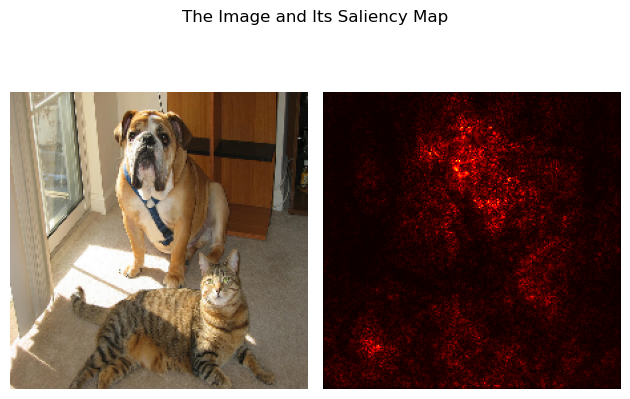

In [13]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import cv2
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

##########################################################################
## TODO: Experiment with other images
# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/CatDog/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

from torch.autograd import Variable
####################################
## TODO: use other models. What happens, if you do not put the pretrained=True? 
####################################
# initialize the VGG model
vgg = vgg19(pretrained=True)
# set the evaluation mode
vgg.eval()
# get the image from the dataloader
img, _ = next(iter(dataloader))
img_var = Variable(img, requires_grad=True)
# get the prediction of the model
pred = vgg(img_var)
# get the most likely prediction of the model; 
# argmax returns the index of the maximum value along an axis
# it's the index of the bull mastiff class in ImageNet
######################################################
## TODO: How to visualize the saliency map for the other classes?
pred_index = pred.argmax(dim=1)
print(pred_index)
# get the gradient of the output with respect to the input image
pred[:, pred_index].backward()
# get the gradient of the input image
saliency, _ = torch.max(img_var.grad.abs(),dim=1)

############# visualization part
saliency = saliency.reshape(224, 224)
# Load the original image
original_image = cv2.imread('./data/CatDog/cls/cat_dog.jpg')
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image = cv2.resize(original_image, (224, 224))
# Reshape the image
image = img.reshape(-1, 224, 224)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)

ax[0].imshow(original_image,cmap='hot')
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()




### Grad-CAM Implementation

In [ ]:
## Standard imports
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# Dataset definition and transforms
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/CatDog/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)


### Task 3: 
* Load the pre-trained model vgg19, 
* Print the model to find out, what is the number of the last convolutional layer is
* Print the summary of the model to find out the dimensions of the feature maps of the last convolutional layer (after activation)
* Define the global variable 'conv_layer_number'

In [ ]:
!pip install torchsummary
from torchsummary import summary

#vgg = 

# conv_layer_number = 


In [ ]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        # dissect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:conv_layer_number+1]
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        # register the hook
        h = x.register_hook(self.activations_hook)
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

### Task 4:
* Get the index of the most likely prediction for the given image (Use the *argmax* function)
* Compute the gradient of the output with respect to the parameters of the model (Use *backward*) for the predicted class
* Pull the gradients out of the model and apply the global average pooling to them. Visualize the gradients.
* Get the activations of the last convolutional layer and visualize them
* Weight the activations by the computed (average pooled) gradients

In [ ]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

#############################################
# TODO 1: get the index of the most likely prediction of the model
# Insert your code here!!!
# ##########################################
pred_index = 0



####################################################
pred = vgg(img)
#############################################
# TODO 2: get the gradient of the output with respect to the parameters of the model
# Insert your code here!!!
# ##########################################
# 

##############################################
# TODO 3: Pull the gradients out of the model and apply the global average pooling
# Insert your code here!!!
# ##########################################
# 
# pull the gradients out of the model
gradients = None
print ('gradients: ',gradients.shape)

# pool the gradients across the channels
pooled_gradients = None
print ('pooled gradients: ',pooled_gradients.shape)

#########################################################
##############################################
# TODO 4: get the activations of the last convolutional layer
# Insert your code here!!!
# ##########################################
# 
activations = None
print ('activations: ',activations.shape)

#########################################################
##############################################
# TODO 5: weight the channels by corresponding gradients
# Insert your code here!!!
# ##########################################
# 
# 
for i in range(512):
    # here you need to change the code!!! This is just a placeholder
    activations*=gradients
#########################################################    
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()
print ('heatmap: ',heatmap.shape)

#print (heatmap)

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

### Here the heatmap is upscaled and overlaid with the original image. 

In [ ]:
!pip install opencv-python
import cv2
print (heatmap.shape)
img = cv2.imread('./data/Elephant/cls/1.png')
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

### Task 5: Experiment with other architectures and compare the Grad-CAM outputs side-by-side

### Task 6 (optional): Experiment with more advanced versions of Grad-CAM from one of the packages